# Procemiento

Debe leer la guía completamente antes de llegar a este paso

se recomienda hacer una copia de este archivo y los scripts de python que lo acompañan. Usted deberá hacer algunas modificaciones en este archivo asi que debe tener precaución.

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

## 1. captura de base de datos

Realizar las grabaciones de cada comando de voz a reconocer y guardar cada grupo en una carpeta diferente.

En la carpeta hay tres archivos que debe mantener junto al código para que todo funcione de forma correcta:

```
tools.py: contiene código para realizar grabaciones y procesar el archivo de audio
wav_rw.py: contiene las funciones para lectura y escritura de audio
helpAudio.py: contiene código para convertir a formato flotante o entero cada audio que proviene de la tarjeta

```


debe instalar 

1. pyAudio: https://pypi.org/project/PyAudio/  

2. scikit-learn: https://scikit-learn.org
3. Librosa: https://librosa.org/doc/latest/index.html

```
pip install pyaudio
pip install scikit-learn
pip install librosa
```

In [4]:
import numpy as np
import random
import pyaudio
from wav_rw import wavwrite
from tools import getAudio
import os
import matplotlib.pyplot as plt

# objeto de pyAudio
p = pyaudio.PyAudio()
fs = 16000  # Hertz
duracion = 2  # cuantos segundos por audio?
##########################################################
#### proceso para varios audios
root = "data"
N = int(input("Digite el numero del comandos a grabar (Cuantas clases diferentes): "))
for n in range(N):
    folderClase = input(f"Digite el NOMBRE del comando numero {n+1} a grabar: ")
    if not os.path.exists(root + "/" + folderClase):
        os.makedirs(root + "/" + folderClase)
    name = folderClase.upper()
    N_audios = int(input(f"Cuantos audios va a grabar para {name}?: "))

    folderDestino = root + "/" + folderClase + "/"

    for i in range(N_audios):
        print(f"[INFO] Grabando el audio numero {i+1}: ")
        x = getAudio(p, RATE=fs, RECORD_SECONDS=duracion)
        file_name = folderDestino + "/audio_" + str(i) + ".wav"
        wavwrite(x, fs, file_name)

print("[INFO] FINALIZADO EL PROCESO, SE HA GENERADO LA BASE DE DATOS")

[INFO] Grabando el audio numero 1: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 2: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 3: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 4: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 5: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 6: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 7: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 8: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 9: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 10: 
[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] Grabando el audio numero 11: 
[I

## 2. procesar audio

Este paso se requiere principalmente en el paso de evaluar el sistema. Si asumimos que la base de datos fue generada en un espacio silencioso y no ha capturado ruido. Vamos a incorporar algunos pasos d procesamiento en la siguiente etapa. 

## 3. segmentar audio

Eliminar segmentos de silencio. En esta etapa vamos a ilustar el proceso, pero luego se va a incorporar al proceso de extracción de caracteristicas.

El proceso consiste en los siguientes pasos:
1. Grabar un audio
2. Normalizar el audio en amplitud
3. Calcular la transformada de Hilbert
4. Calcular la envolvente de Hilbert
5. Filtrar la envolvente de Hilbert con un filtro FIR de paso bajo con frecuencia de corte a 20Hz, la razon para la frecuencia de corte tiene que ver con la frecuencia con la que los humanos relizamos movimientos con la mandibula para producir sonidos
6. Usar un umbral para eliminar los silencios y dejar solo el audio 



[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!


Text(0.5, 1.0, 'Senal sementada (sin silencio en los extremos)')

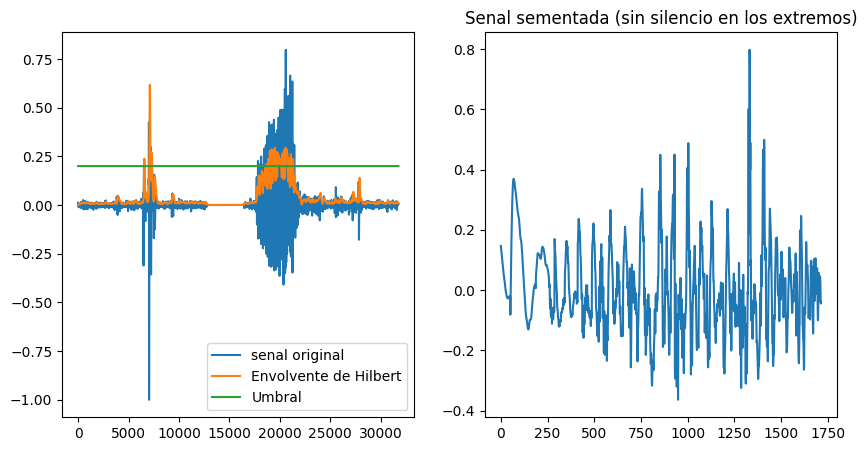

In [9]:
from scipy import signal

fs=16000
umbral = 0.2 #ajustar si es necesario
#filtro 20hz
b = signal.firwin(128, 20/(fs/2), window='hamming', pass_zero=True)


x=getAudio(p,RATE=fs,RECORD_SECONDS=2)
x=x/np.max(abs(x))
s=signal.hilbert(x)
Eh = np.abs(s) #20*np.log10(np.abs(s))/(20*np.log10(np.abs(s))).max()
Eh = signal.lfilter(b, 1, Eh)
#tomar solo las partes mayores a 0.2, xs es la senal segmentada
xs = x[Eh>umbral]

##### mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x,label="senal original")
plt.plot(Eh,label="Envolvente de Hilbert")
plt.plot(umbral*np.ones(Eh.size),label="Umbral")
plt.legend()

plt.subplot(122)
plt.plot(xs)
plt.title("Senal sementada (sin silencio en los extremos)")



## 4.  Extracción de Características

Vamos repetir el proceso anterior para cada uno de los audios, esto nos permitirá eliminar los segmentos de silencio. Luego, a cada audio se le calculan 3 características. Por medio de histogramas vamos a evaluar si las caracteristicas calculadas nos pueden servir para diferenciar los comandos.

Tambien se mostrará el espectro promedio de cada clase para dar una mejor idea de las bandas de frecuencia a tener en cuenta.

**Enfoque 1**

La energía por si sola no se espera que sea un factor discriminante, pero si es posible que se presenten valores de energia de diferentes en bandas especificas. Si analizamos el espectro para el ejemplo dado, notaremos que la energía en la banda 0 - 1000, es diferente de la energía de la banda de 1000 a 2000, (en bins es de 0 a 50 y de 50 a 100). Entonces calculamos la energía en la primer banda y la dividimos entre la energía en la segunda banda y eso nos da una relación de energía.

Por otro lado, cada comando puede tener diferentes fonemas, donde las vocales son las mas fuertes. Entonces calcularemos los formantes 1 y 2, que corresponden a los ángulos de las dos primeras raices positivas del filtro LPC estimado para un segmento de voz. 

Finalmente se aplica PCA para poder visualizar cada comando como un punto en 2 dimensiones. 

**Considera usted que el enfoque 1 es un buen enfoque para diferenciar los comandos de voz?**

[INFO] los comandos son: ['down' 'left' 'right' 'up']
....................................................................................................
[INFO] finalizado


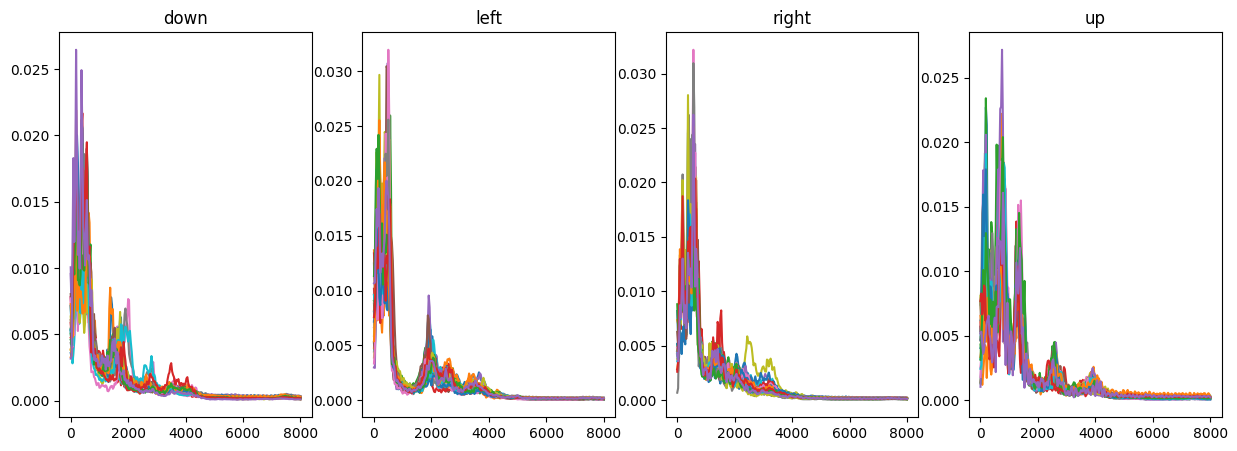

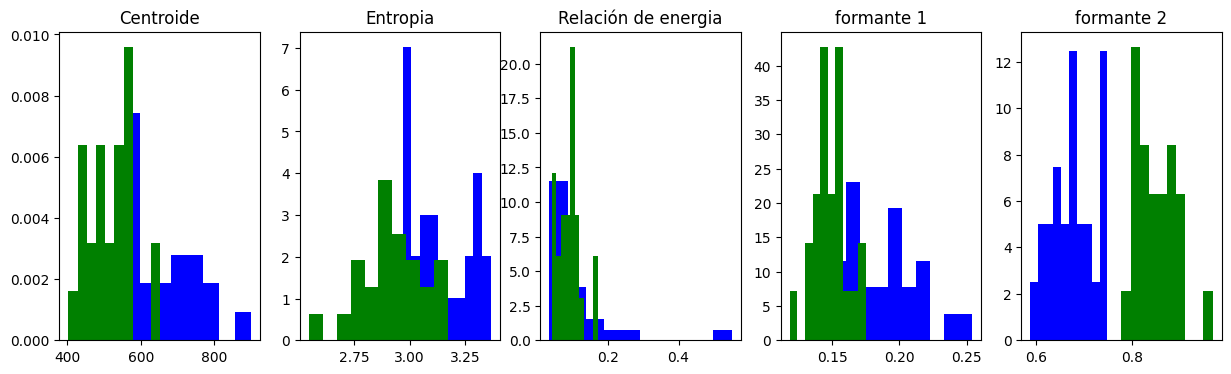

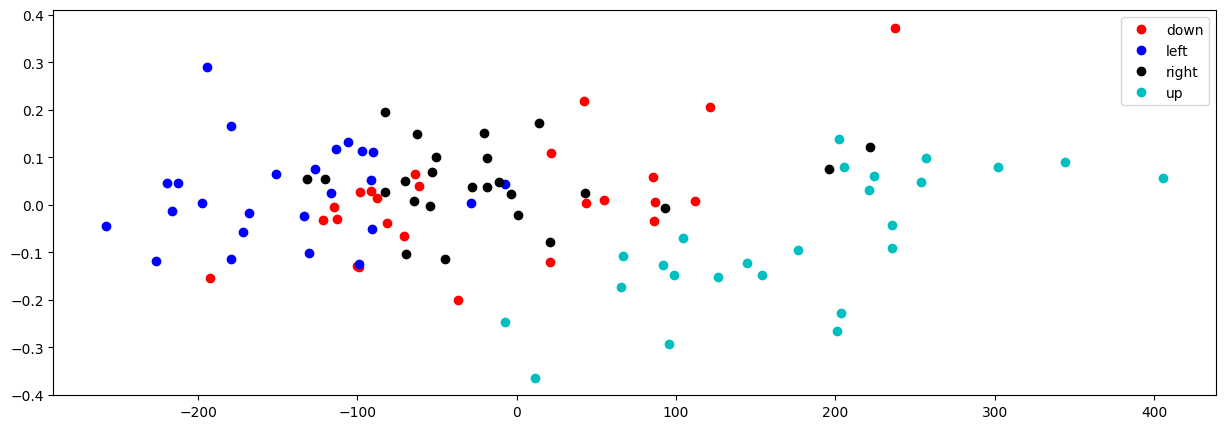

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from wav_rw import wavread
from tools import enframe, calFeatures
import os
from scipy import signal

## leer todos los archivos
root = "data"
file_names = glob(root + "/**/*.wav", recursive=True)
clases = glob(root + "/*")
clases = np.array([clase.split(os.path.sep)[1] for clase in clases])
print("[INFO] los comandos son:", clases)
# crear un diccionario vacio para poder guardar los espectros de cada clase,
# es unicamente para poder visualizar
# tambien se crea una lista data vacia para guardar las otras caracteristicas y un vector
# de ceros, para poner una etiqueta, 0, 1, 2, 3.... para identificar cada comando por un valor entero

espectros = dict()
for clase in clases:
    espectros[clase] = []
data1 = []
labels1 = np.zeros(len(file_names)).astype(int)


NFFT = 512
umbral = 0.15
# leer los audios e iterar
X = []
y = []

for i, file_name in enumerate(file_names):
    print(".", end="")
    fs, x = wavread(file_name)
    x = x / np.max(abs(x))
    # filtro 20Hz
    b = signal.firwin(128, 20 / (fs / 2), window="hamming", pass_zero=True)
    s = signal.hilbert(x)
    Eh = np.abs(s)
    Eh = signal.lfilter(b, 1, Eh)
    # tomar solo las partes mayores a 0.2
    x = x[Eh > umbral]
    ############################################################################
    ## calcular espectro
    M = int(fs * 0.025)
    H = int(fs * 0.010)
    xf, _ = enframe(x, window="hamming", M=M, H=H)
    X = []
    for frame in xf:
        X.append(np.abs(np.fft.rfft(frame, NFFT) / NFFT))
        # X.append(20*np.log10(np.abs(np.fft.rfft(frame,NFFT)/NFFT)))
    X = np.vstack(X)
    X = X.mean(axis=0)
    # agrupar por clase
    for j, clase in enumerate(clases):
        if clase in file_name:
            espectros[clase].append(X)
            labels1[i] = j
    ### calcular centroide, entropia y relacion de energia entre bandas
    ##################################################################################
    Fc, HH, Er, f1, f2 = calFeatures(x, fs, M, H, NFFT)
    feats = np.array([Fc, HH, Er, f1, f2])
    data1.append(feats)


print("\n[INFO] finalizado")
data1 = np.vstack(data1)

f = np.linspace(0, 1, NFFT // 2 + 1) * fs / 2
plt.figure(figsize=(15, 5))
for i, clase in enumerate(clases):
    X = np.vstack(espectros[clase])
    plt.subplot(1, 4, i + 1)
    plt.plot(f, X.T)
    plt.title(clase)

plt.figure(figsize=(15, 4))
legends = ["Centroide", "Entropia", "Relación de energia", "formante 1", "formante 2"]
for i in range(5):
    x = data1[:, i]
    plt.subplot(1, 5, i + 1)
    h1 = plt.hist(x[labels1 == 0], 10, density=True, color="blue")
    h0 = plt.hist(x[labels1 == 1], 10, density=True, color="green")
    plt.title(legends[i])


#### aplicar pca para reducir dimensiones
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data1)

X = pca.transform(data1)
plt.figure(figsize=(15, 5))
color = "rbkc"
for j, clase in enumerate(clases):
    key = "o" + color[j]
    plt.plot(X[labels1 == j, 0], X[labels1 == j, 1], key, label=clase)
plt.legend()

**Enfoque 2**

Dado que calcular características de forma individual puede ser un proceso demandante y muy dependiente de la tarea a realizar. En este enfoque se calcula el espectrograma de mel para cada audio. Esto genera una matriz donde cada fila es una banda y cada columna corresponde a un frame o ventana. Usaremos PCA para reducir a dos componentes y poder visualizar si el espectrograma es suficiente para diferenciar los comandos de voz.

En este caso se usan 27 bandas, es decir la matriz es de 27 x el numero de ventanas que se puedan segmentar del audio. Como el numero de ventanas es variable, se calcula la matriz de covarianza y se toma la triangular superior. Esta porcion de la triangular superior se vectoriza y se aplica PCA.

**Considera usted que el enfoque 2 es un buen enfoque para diferenciar los comandos de voz?**

[INFO] los comandos son: ['down' 'left' 'right' 'up']
....................................................................................................

c:\Users\Windows 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=351
  warnings.warn(


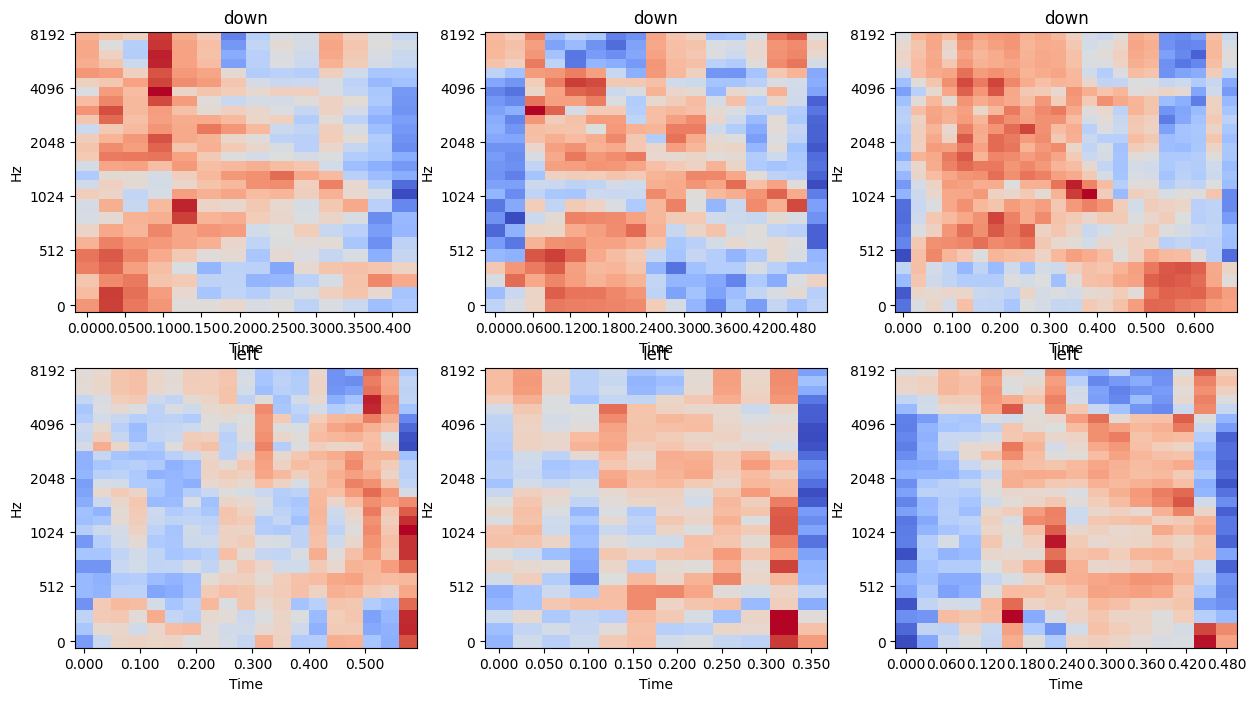

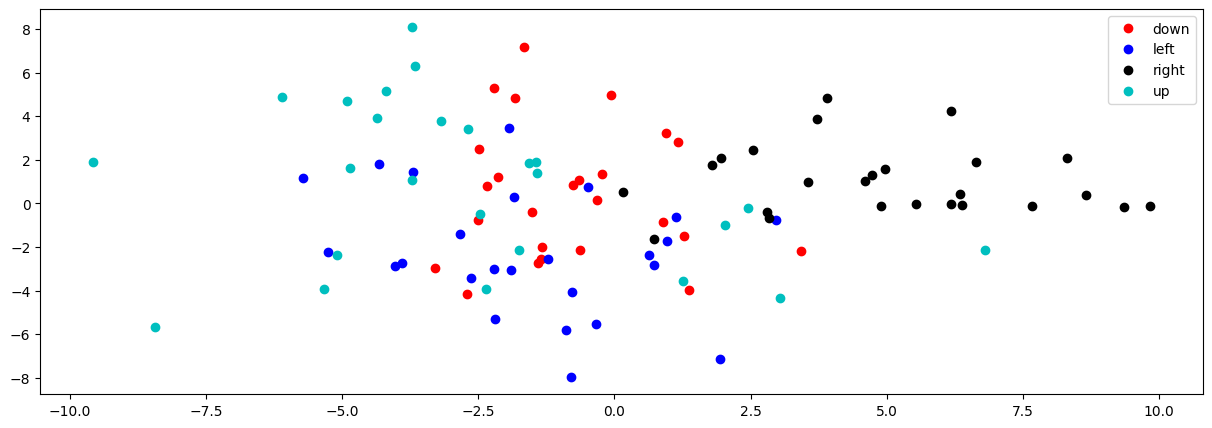

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from wav_rw import wavread
from tools import enframe, melspec_lr
import os
from scipy import signal
import librosa

## leer todos los archivos
root = "data"
file_names = glob(root + "/**/*.wav", recursive=True)
clases = glob(root + "/*")
clases = clases = np.array([clase.split(os.path.sep)[1] for clase in clases])
print("[INFO] los comandos son:", clases)

data2 = []
labels2 = np.zeros(len(file_names)).astype(int)


NFFT = 512
umbral = 0.2
# leer los audios e iterar
X = []
y = []
count = [0, 0]
k = 0
plt.figure(figsize=(15, 8))
for i, file_name in enumerate(file_names):
    print(".", end="")
    fs, x = wavread(file_name)
    x = x / np.max(abs(x))
    # filtro 20Hz
    b = signal.firwin(128, 20 / (fs / 2), window="hamming", pass_zero=True)
    s = signal.hilbert(x)
    Eh = np.abs(s)
    Eh = signal.lfilter(b, 1, Eh)
    # tomar solo las partes mayores a 0.2
    x = x[Eh > umbral]
    ############################################################################
    ## calcular espectro
    M = int(fs * 0.025)
    H = int(fs * 0.010)
    mel = melspec_lr(x, fs, hop_length=H, win_length=M, n_mels=27)
    s = np.cov(mel)
    # calcular la triangular superior de la matriz de covarianzas del espectro de mel
    data2.append(s[np.triu_indices(s.shape[0])])

    for j, clase in enumerate(clases):
        if clase in file_name:
            labels2[i] = j

    # mostrar 6 ejemplos, 3  de cada clase
    if count[0] < 3:
        if clases[0] in file_name:

            plt.subplot(2, 3, k + 1)
            librosa.display.specshow(mel, x_axis="time", y_axis="mel", sr=fs)
            plt.title(clases[0])
            count[0] += 1
            k += 1

    if count[1] < 3:

        if clases[1] in file_name:

            plt.subplot(2, 3, k + 1)
            librosa.display.specshow(mel, x_axis="time", y_axis="mel", sr=fs)
            plt.title(clases[1])
            count[1] += 1
            k += 1


data2 = np.vstack(data2)
#### aplicar pca para reducir dimensiones
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data2)

X = pca.transform(data2)
plt.figure(figsize=(15, 5))
color = "rbkc"
for j, clase in enumerate(clases):
    key = "o" + color[j]
    plt.plot(X[labels2 == j, 0], X[labels2 == j, 1], key, label=clase)
plt.legend()

## 5. Modelo de Reconocimiento Automático comandos de voz

La regresión logística es un modelo de aprendizaje supervisado utilizado para la clasificación binaria, donde el objetivo es predecir la probabilidad de pertenencia a una de las dos categorías posibles. El modelo se puede extender multiples categorias, en scikit-learn no es necesario hacer ajustes adicionales. A diferencia de la regresión lineal, la regresión logística utiliza la función logística para transformar la salida de una combinación lineal de características en un valor entre 0 y 1, interpretado como la probabilidad de pertenencia a la categoría positiva. Este modelo es particularmente útil en problemas donde la relación entre las variables explicativas y la respuesta es no lineal, y es ampliamente empleado en campos como la medicina, la biología y la clasificación de texto.

Se debe reservar una pequeña porcion de los datos para entrenar el modelo y otra porcion para poder hacer la prueba. Normalmente se usar 70% para entrenar y 30% para probar el modelo.

AL correr varias veces el siguiente código notaran que el enfoque 1 puede funcionar en determinadas circunstancias, pero en otras situaciones no da un buen porcentaje. Por lo tanto nuestro sistema lo implementaremos con el enfoque 2. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# usar enfoque 1
x_train, x_test, y_train, y_test = train_test_split(data1, labels1, test_size=0.3)
print("[INFO] entrenando....")
# entrenar un clasificador simple
clf = LogisticRegression(solver="lbfgs", max_iter=3000)
clf.fit(x_train, y_train)
print("[INFO] evaluando....")
y = clf.predict(x_test)
acc = (y == y_test).sum() / y.size * 100
print("[INFO] Porcentaje de prediccion usando enfoque 1: ", acc)

# usar enfoque 2
x_train, x_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.3)
print("[INFO] entrenando....")
# entrenar un clasificador simple
clf = LogisticRegression(solver="lbfgs", max_iter=3000)
clf.fit(x_train, y_train)
print("[INFO] evaluando....")
y = clf.predict(x_test)
acc = (y == y_test).sum() / y.size * 100
print("[INFO] Porcentaje de prediccion usando enfoque 2: ", acc)

[INFO] entrenando....
[INFO] evaluando....
[INFO] Porcentaje de prediccion usando enfoque 1:  53.333333333333336
[INFO] entrenando....
[INFO] evaluando....
[INFO] Porcentaje de prediccion usando enfoque 2:  93.33333333333333


## algoritmo completo para extraer caracteristicas y para entrenar el modelo




In [15]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from wav_rw import wavread
from tools import melspec_lr
import os
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

## leer todos los archivos
root = "data"
file_names = glob(root + "/**/*.wav", recursive=True)
clases = glob(root + "/*")
clases = clases = np.array([clase.split(os.path.sep)[1] for clase in clases])
print("[INFO] los comandos son:", clases)

data2 = []
labels2 = np.zeros(len(file_names)).astype(int)

NFFT = 512
umbral = 0.2
# leer los audios e iterar

for i, file_name in enumerate(file_names):
    print(".", end="")
    fs, x = wavread(file_name)
    x = x / np.max(abs(x))
    # filtro 20Hz
    b = signal.firwin(128, 20 / (fs / 2), window="hamming", pass_zero=True)
    s = signal.hilbert(x)
    Eh = np.abs(s)
    Eh = signal.lfilter(b, 1, Eh)
    # tomar solo las partes mayores a 0.2
    x = x[Eh > umbral]
    ############################################################################
    ## calcular espectro
    M = int(fs * 0.025)
    H = int(fs * 0.010)
    mel = melspec_lr(x, fs, hop_length=H, win_length=M, n_mels=27)
    s = np.cov(mel)
    # calcular la triangular superior de la matriz de covarianzas del espectro de mel
    data2.append(s[np.triu_indices(s.shape[0])])
    for j, clase in enumerate(clases):
        if clase in file_name:
            labels2[i] = j

print(".")
data2 = np.vstack(data2)
# usar enfoque 2
x_train, x_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.3)
print("[INFO] entrenando....")
# entrenar un clasificador simple
clf = LogisticRegression(solver="lbfgs", max_iter=3000)
clf.fit(x_train, y_train)
print("[INFO] evaluando....")
y = clf.predict(x_test)
acc = (y == y_test).sum() / y.size * 100
print("[INFO] Porcentaje de prediccion usando enfoque 2: ", acc)


# guardar para posterior uso
print("[INFO] guardando el modelo")
with open("clasificador.pkl", "wb") as fh:
    pickle.dump(clf, fh)

with open("clases.pkl", "wb") as fh:
    pickle.dump(clases, fh)
print("[INFO] hecho!!")

[INFO] los comandos son: ['down' 'left' 'right' 'up']
.....................................................................................................
[INFO] entrenando....
[INFO] evaluando....
[INFO] Porcentaje de prediccion usando enfoque 2:  93.33333333333333
[INFO] guardando el modelo
[INFO] hecho!!


c:\Users\Windows 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=351
  warnings.warn(


# 6. Decodificación

Usar el modelo para decodificar el audio que se captura con el microfono. En esta etapa es necesario procesar un solo audio y pasarlo por el modelo. 

In [26]:
from sklearn.linear_model import LogisticRegression
import pickle
from scipy import signal
import pyaudio
from tools import getAudio

# 1. Crear objeto de pyAudio
p = pyaudio.PyAudio()
fs = 16000  # Hertz
duracion = 3  # cuantos segundos por audio?

##2. cargar el modelo y las etiquetas
fh = open("clasificador.pkl", "rb")
clf = pickle.load(fh)
fh.close()

# etiquetas
fh = open("clases.pkl", "rb")
clases = pickle.load(fh)
fh.close()

##3. capturar audio usando el microfono y hacer todo el proceso hasta calcular las caracteristicas
# filtro 20hz
b = signal.firwin(128, 20 / (fs / 2), window="hamming", pass_zero=True)
x = getAudio(p, RATE=fs, RECORD_SECONDS=2)
x = x / np.max(abs(x))
s = signal.hilbert(x)
Eh = np.abs(s)
Eh = signal.lfilter(b, 1, Eh)
# tomar solo las partes mayores a 0.2, xs es la senal segmentada
xs = x[Eh > umbral]
## calcular espectro de mel
M = int(fs * 0.025)
H = int(fs * 0.010)
mel = melspec_lr(xs, fs, hop_length=H, win_length=M, n_mels=27)
s = np.cov(mel)
# calcular la triangular superior de la matriz de covarianzas del espectro de mel
feats = s[np.triu_indices(s.shape[0])]

# 4. realizar prediccon usando el modelo
prediction = clf.predict(feats.reshape(1, -1))
print(f"[INFO] comando reconocido: {clases[prediction][0]}")

[INFO] Escuchando  durante 2 segundos...
[INFO] finalizado!
[INFO] comando reconocido: down
